In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('../data/bm2019pm.csv', index_col='datetime', parse_dates=True)

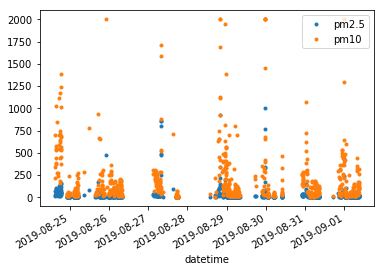

In [4]:
df[['pm2.5', 'pm10']].plot(style='.')

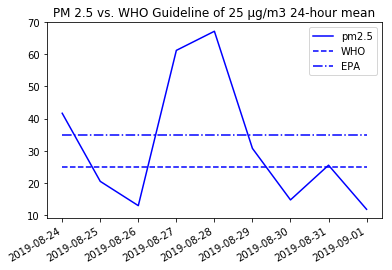

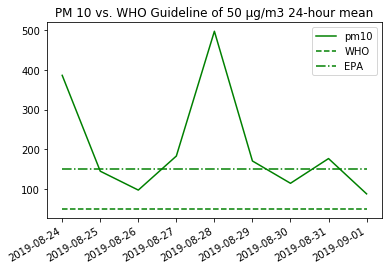

In [36]:
df_daily = df.groupby(df.index.date)[['pm2.5', 'pm10']].mean()
df_daily['pm2.5'].plot(style='b')
plt.plot(pd.DataFrame(np.ones(len(df_daily)) * 25, index=df_daily.index), 'b--', label='WHO')
plt.plot(pd.DataFrame(np.ones(len(df_daily)) * 35, index=df_daily.index), 'b-.', label='EPA')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('PM 2.5 vs. WHO Guideline of 25 μg/m3 24-hour mean')
pass
plt.figure()
df_daily['pm10'].plot(style='g')
plt.plot(pd.DataFrame(np.ones(len(df_daily)) * 50, index=df_daily.index), 'g--', label='WHO')
plt.plot(pd.DataFrame(np.ones(len(df_daily)) * 150, index=df_daily.index), 'g-.', label='EPA')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('PM 10 vs. WHO Guideline of 50 μg/m3 24-hour mean')
pass

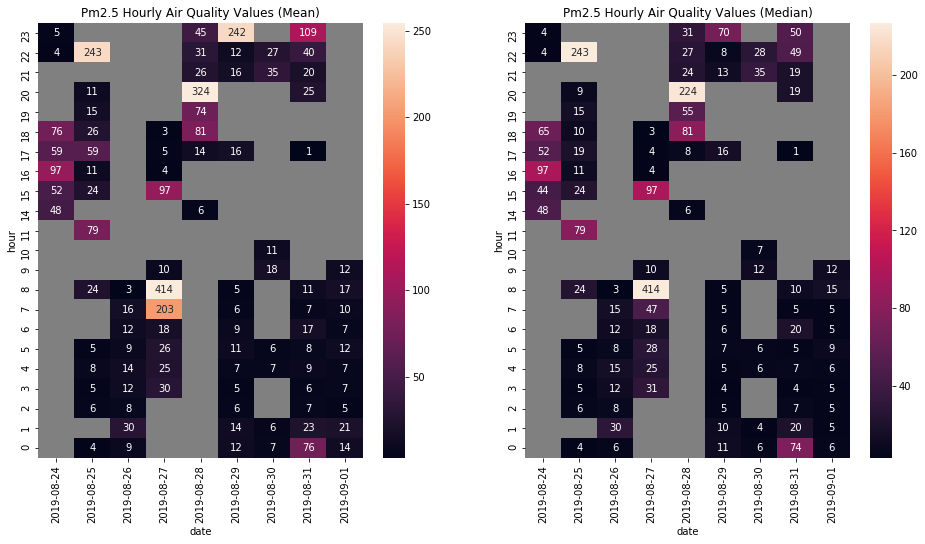

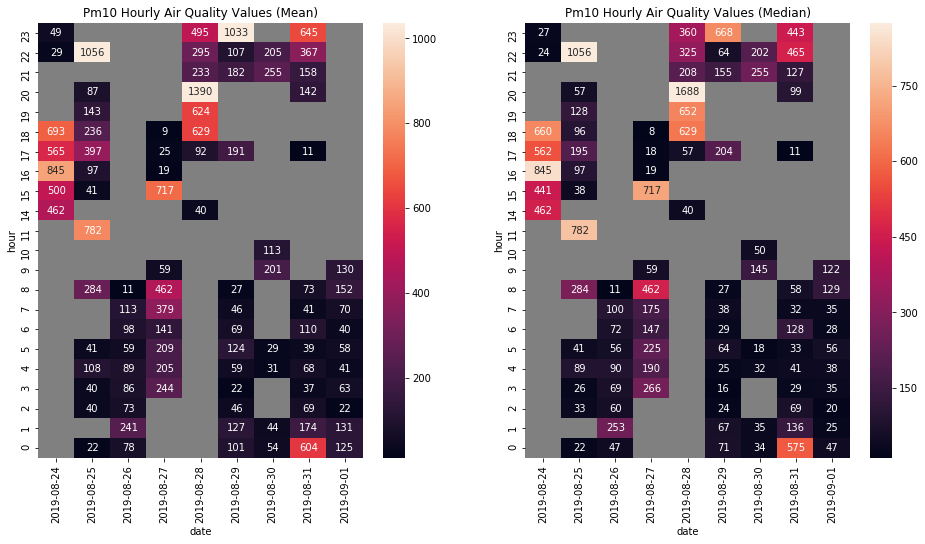

In [5]:
def get_heatmap_df(var, avg_type='mean'):
    df_heatmap = df[var].groupby([df.index.date, df.index.hour])
    if avg_type == 'mean':
        df_heatmap = df_heatmap.mean()
    elif avg_type == 'median':
        df_heatmap = df_heatmap.median()
    df_heatmap = df_heatmap.reset_index()
    df_heatmap.columns = ['date', 'hour', var]
    df_heatmap_pivoted = df_heatmap.pivot(
        index='hour', columns='date', values=var).sort_index(ascending=False
    ).round()
    return df_heatmap_pivoted

for var in ['pm2.5', 'pm10']:
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    for i, avg_type in enumerate(['mean', 'median']):
        cmap = sns.cm.rocket
        cmap = cmap.set_bad("grey") 
        axes[i].title.set_text('{} Hourly Air Quality Values ({})'.format(var, avg_type).title())
        sns.heatmap(get_heatmap_df(var, avg_type), annot=True, cmap=cmap, robust=True, fmt='g', ax=axes[i])

##Initial Attempt at Correlating to Weather Data

See `get_weather.py` to see where this data came from.

In [6]:
df_weather = pd.read_csv('../data/weather/gerlach_weather.csv', index_col='datetime', parse_dates=True)
df_weather = df_weather.resample('900S').mean()

In [7]:
df_w_weather = df.resample('900S').mean().join(df_weather)
df_w_weather.rename(columns={'pm2.5':'pm25'}, inplace=True)

In [8]:
df_weather.keys()

Index(['dewptAvg', 'dewptHigh', 'dewptLow', 'heatindexAvg', 'heatindexHigh',
       'heatindexLow', 'precipRate', 'precipTotal', 'pressureMax',
       'pressureMin', 'pressureTrend', 'tempAvg', 'tempHigh', 'tempLow',
       'windchillAvg', 'windchillHigh', 'windchillLow', 'windgustAvg',
       'windgustHigh', 'windgustLow', 'windspeedAvg', 'windspeedHigh',
       'windspeedLow'],
      dtype='object')

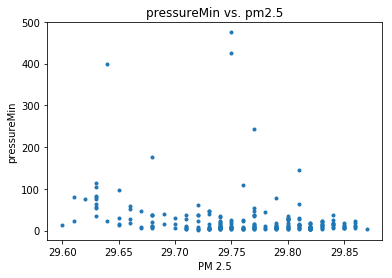

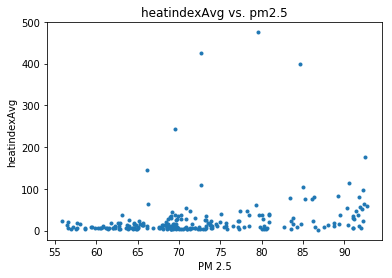

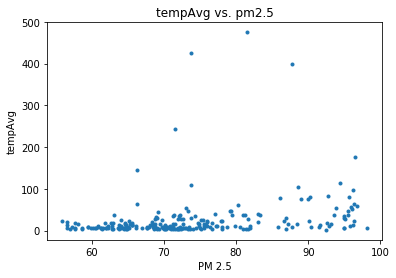

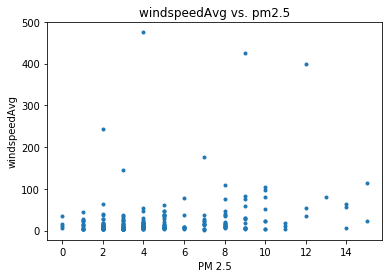

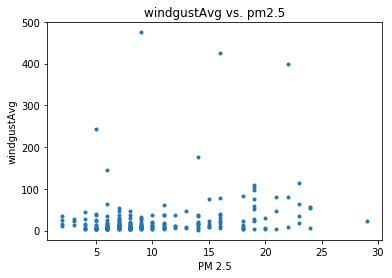

In [9]:
for key in ['pressureMin', 'heatindexAvg', 'tempAvg', 'windspeedAvg', 'windgustAvg']:
    plt.figure()
    plt.plot(df_w_weather[key], df_w_weather['pm25'],'.')
    plt.title('{} vs. pm2.5'.format(key))
    plt.xlabel('PM 2.5')
    plt.ylabel(key)

In [10]:
import statsmodels.formula.api as smf

In [11]:
model = smf.wls(formula='pm25 ~ windgustAvg', data=df_w_weather)
result = model.fit()

In [12]:
result.rsquared

0.05606301986146267

In [13]:
max_val = int(df_w_weather['pm25'].max())
line = [result.params['Intercept'] + result.params['windgustAvg'] * x for x in range(0,max_val)]

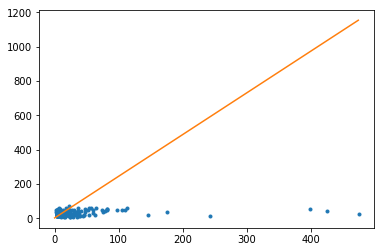

In [14]:
predicted = result.predict(df_w_weather['windgustAvg'])
plt.plot(df_w_weather['pm25'], predicted, '.')
plt.plot(line)